## 0. import some important package

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## 1. load the data 

Use the data from "[_Microsoft Anonymous Web Data_](http://kdd.ics.uci.edu/databases/msweb/msweb.html)".  
Notice: from the describtion }(http://kdd.ics.uci.edu/databases/msweb/msweb.html), the data in file mainly have 2 parts, "attribute" and "user".


### 1.1 Attribute data

In [2]:
attribute_df = pd.read_csv("anonymous-msweb.data",header=None,skiprows=range(0,7),nrows=293, names=['marks', 'attribute ID','ignored','title','url'])
attribute_df.describe()

,attribute ID,ignored
count,293.000000,293.0
mean,1147.197952,1.0
std,85.435999,0.0
min,1000.000000,1.0
25%,1074.000000,1.0
50%,1147.000000,1.0
75%,1221.000000,1.0
max,1297.000000,1.0


### 1.2 User data

In [3]:
user_df = pd.read_csv("anonymous-msweb.data",header=None,skiprows=range(0,301), names=['marks', 'ID','ignored'])
user_df.head(10)

,marks,ID,ignored
0,C,10001,10001
1,V,1000,1
2,V,1001,1
3,V,1002,1
4,C,10002,10002
5,V,1001,1
6,V,1003,1
7,C,10003,10003
8,V,1001,1
9,V,1003,1


## 2. Preprocess the data
The original data did not meet our requirements very well, so some preprocessing was performed to facilitate subsequent data mining
### 2.1 Process attribute data
From the _describtion_, "marks" and "ignored" are useless to our data, "url" seems not helpful for our mining task.

In [4]:
url_save = attribute_df['url']
attribute_df.drop(['marks','ignored'],axis=1,inplace=True)
id2name = pd.Series(attribute_df['title'].values,index=attribute_df['attribute ID']).to_dict()

After the procrss applyed, the data become:

In [5]:
attribute_df.sample(5)

,attribute ID,title,url
104,1162,IIS Support,/infoservsupport
151,1255,Message Queue Server,/msmq
60,1280,MS Interactive Music Control,/music
21,1147,Microsoft Financial Forum,/msft
37,1222,MS Office News,/msofc


### 2.2 Process user data
Mark "C" means a new case (user), "V" means a vote.  
We want to know the meeting sequence for each user, so change the data structure as {_user:visit sequence_}

In [6]:
user = []
record = []
temp_sequence = None
for index, row in user_df.iterrows():
    if row['marks']=='C':
        if temp_sequence!= None:
            record.append(temp_sequence)
        user.append(row['ID'])
        temp_sequence=[]
    else:
        temp_sequence.append(row['ID'])
record.append(temp_sequence)
user_df = pd.DataFrame({"user":user,"visit":record})
user_df.sample(5)

,user,visit
12639,22640,"[1020, 1004]"
15602,25603,[1034]
24270,34271,"[1035, 1136, 1001, 1004, 1018]"
28149,38150,[1001]
31774,41775,"[1008, 1009, 1018, 1004, 1034]"


After changing the structure, the user data is follwing:

In [7]:
user_df.sample(5)

,user,visit
15761,25762,"[1034, 1004]"
24259,34260,[1007]
31957,41958,"[1062, 1082, 1018, 1004]"
437,10438,[1147]
15454,25455,"[1025, 1026]"


## 3. Explore on data
### 3.1 all attribute visited time

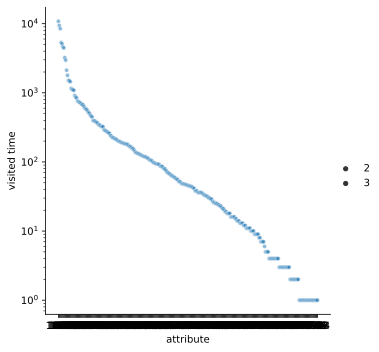

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
record_dict = {}
for index, row in user_df.iterrows():
    sequence=row['visit']
    for i in sequence:
        if i in record_dict.keys():
            record_dict[i]+=1
        else:
            record_dict[i]=1
attr_list = [i for i in record_dict.keys()]
hit_list = [record_dict[i] for i in attr_list]
hit_df = pd.DataFrame({"attribute":attr_list,"visited time":hit_list})
hit_df.sort_values("visited time",inplace=True,ascending=[False])
hit_df['attribute']= hit_df['attribute'].map(lambda x:str(x))
sns.relplot(x="attribute",y="visited time",data=hit_df,size=3, alpha=0.5).set(yscale='log')
plt.savefig('test1.svg',dpi=600)

In [9]:
hit_df["attribute"] = hit_df["attribute"].map(lambda x:int(x))
attribute_df=pd.merge(attribute_df,hit_df,how='left',left_on="attribute ID",right_on="attribute")
attribute_df.drop(columns="attribute",inplace=True)
attribute_df["visited time"] = attribute_df["visited time"].fillna(0)
attribute_df["visited time"].describe(percentiles=[.33, .66])

count      293.000000
mean       336.686007
std       1156.420373
min          0.000000
33%         14.360000
50%         44.000000
66%        109.880000
max      10836.000000
Name: visited time, dtype: float64

In [10]:
attribute_df["visited time"].describe(percentiles=[.33, .66])

count      293.000000
mean       336.686007
std       1156.420373
min          0.000000
33%         14.360000
50%         44.000000
66%        109.880000
max      10836.000000
Name: visited time, dtype: float64

#### 3.1.1 some web are never visited

In [11]:
attribute_df.sort_values("visited time",inplace=True)
attribute_df[attribute_df["visited time"]==0]["title"]

0               International AutoRoute
1                               library
2       Master Chef Product Information
3                       Central America
41                              Encarta
164                                news
209                     MS North Africa
211    Activate the Internet Conference
39                            Bookshelf
Name: title, dtype: object

#### 3.1.2 top 10 hottest website

In [17]:
attribute_df.sort_values("visited time",inplace=True,ascending=[False])
attribute_df.head(10)[["title","visited time",'url']]

,title,visited time,url
57,Free Downloads,10836.0,/msdownload
283,Internet Explorer,9383.0,/ie
17,Microsoft.com Search,8463.0,/search
287,isapi,5330.0,/isapi
212,Products,5108.0,/products
157,Windows Family of OSs,4628.0,/windows
78,Support Desktop,4451.0,/support
23,Internet Site Construction for Developers,3220.0,/sitebuilder
30,Knowledge Base,2968.0,/kb
122,Web Site Builder's Gallery,2123.0,/gallery


In [19]:
# user visited length
user_df["visit len"] = user_df.apply(lambda x: len(x['visit']), axis=1)
user_df

,user,visit,visit len
0,10001,"[1000, 1001, 1002]",3
1,10002,"[1001, 1003]",2
2,10003,"[1001, 1003, 1004]",3
3,10004,[1005],1
4,10005,[1006],1
5,10006,"[1003, 1004]",2
6,10007,[1007],1
7,10008,[1004],1
8,10009,"[1008, 1009]",2
9,10010,"[1010, 1000, 1011, 1012, 1013, 1014]",6


### 3.2 visit len

In [34]:
user_df["visit len"].describe(percentiles=[.33, .70,.85])

count    32711.000000
mean         3.015927
std          2.496459
min          1.000000
33%          2.000000
50%          2.000000
70%          3.000000
85%          5.000000
max         35.000000
Name: visit len, dtype: float64

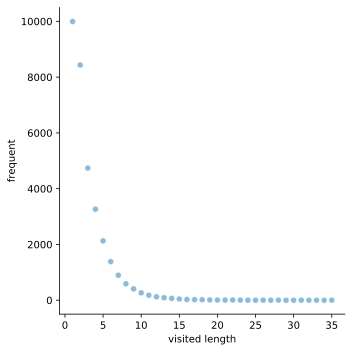

In [29]:
visit_len = user_df["visit len"].to_list()
visit_len_record = {i:0 for i in range(1,36)}
for i in visit_len:
    visit_len_record[i]+=1
len_df = pd.DataFrame({"frequent":[visit_len_record[i] for i in range(1,36)],"visited length":[i for i in range(1,36)]})
len_df.sort_values("visited length",inplace=True,ascending=[False])
sns.relplot(x="visited length",y="frequent",data=len_df, alpha=0.5)
plt.savefig("test2.jpg",dpi=600)

### 3.3 Association Rule Mining -Apriori

In [14]:
import myApriori

In [38]:
l, supportdata = myApriori.apriori(user_df['visit'],id2name,min_support=0.05)

=========k = 1==========
['Support Desktop'] 0.13607
['Knowledge Base'] 0.09073
['Microsoft.com Search'] 0.25872
['Windows Family of OSs'] 0.14148
['Free Downloads'] 0.33126
['Products '] 0.15616
['isapi'] 0.16294
["Web Site Builder's Gallery"] 0.06490
['Internet Site Construction for Developers'] 0.09844
['Internet Explorer'] 0.28685
['Windows95 Support'] 0.05475
=========k = 2==========
['Support Desktop', 'Knowledge Base'] 0.05521
['Free Downloads', 'Windows Family of OSs'] 0.07792
['Free Downloads', 'Microsoft.com Search'] 0.06044
['Free Downloads', 'isapi'] 0.07306
['Free Downloads', 'Products '] 0.06123
['Free Downloads', 'Internet Explorer'] 0.16080
['Internet Explorer', 'Microsoft.com Search'] 0.05328
['Support Desktop', 'isapi'] 0.05943
=========k = 3==========


In [37]:
l, supportdata = myApriori.apriori(user_df['visit'],id2name,min_support=0.03)

=========k = 1==========
['Support Desktop'] 0.13607
['Knowledge Base'] 0.09073
['Microsoft.com Search'] 0.25872
['Windows Family of OSs'] 0.14148
['Free Downloads'] 0.33126
['Products '] 0.15616
['isapi'] 0.16294
['Developer Network'] 0.03323
["Web Site Builder's Gallery"] 0.06490
['Internet Site Construction for Developers'] 0.09844
['Windows NT Server'] 0.03409
['Games'] 0.04421
['Internet Explorer'] 0.28685
['Windows95 Support'] 0.05475
['Developer Workshop'] 0.04586
['Windows 95'] 0.03546
['MS Office Info'] 0.04604
['SiteBuilder Network Membership'] 0.03393
=========k = 2==========
['Support Desktop', 'Knowledge Base'] 0.05521
['Support Desktop', 'Microsoft.com Search'] 0.04858
['Knowledge Base', 'Microsoft.com Search'] 0.03916
['Free Downloads', 'Windows Family of OSs'] 0.07792
['Products ', 'isapi'] 0.03684
["Web Site Builder's Gallery", 'Internet Site Construction for Developers'] 0.03531
['Free Downloads', 'Microsoft.com Search'] 0.06044
['isapi', 'Microsoft.com Search'] 0.044

### 3.4 Sequential Association Rule Mining 

In [40]:
l, supportdata = myApriori.seq_apriori(user_df['visit'],id2name,min_support=0.04)

=========k = 1==========
['Support Desktop'] 0.13607
['Knowledge Base'] 0.09073
['Microsoft.com Search'] 0.25872
['Free Downloads'] 0.33126
['Windows Family of OSs'] 0.14148
['Products '] 0.15616
['isapi'] 0.16294
["Web Site Builder's Gallery"] 0.06490
['Internet Site Construction for Developers'] 0.09844
['Games'] 0.04421
['Internet Explorer'] 0.28685
['Windows95 Support'] 0.05475
['MS Office Info'] 0.04604
['Developer Workshop'] 0.04586
=========k = 2==========
['Free Downloads', 'Windows Family of OSs'] 0.07664
['Products ', 'Microsoft.com Search'] 0.04989
['Free Downloads', 'Internet Explorer'] 0.15912
['Products ', 'Internet Explorer'] 0.04613
['Free Downloads', 'Microsoft.com Search'] 0.04833
['Free Downloads', 'Products '] 0.04763
['Free Downloads', 'isapi'] 0.05915
['Support Desktop', 'isapi'] 0.04806
=========k = 3==========


### 3.5 Advanced Sequential Association Rule Mining 

In [61]:
l, supportdata = myApriori.seq_apriori(user_df[user_df["visit len"]<=7]['visit'],id2name,min_support=0.04)

=========k = 1==========
['Support Desktop'] 0.11715
['Knowledge Base'] 0.07500
['Microsoft.com Search'] 0.24225
['Free Downloads'] 0.31245
['Windows Family of OSs'] 0.12315
['Products '] 0.13181
['isapi'] 0.13755
["Web Site Builder's Gallery"] 0.06064
['Internet Site Construction for Developers'] 0.08437
['Internet Explorer'] 0.27542
['Games'] 0.04115
['Windows95 Support'] 0.04494
=========k = 2==========
['Free Downloads', 'Windows Family of OSs'] 0.06394
['Free Downloads', 'Internet Explorer'] 0.14877
['Free Downloads', 'Microsoft.com Search'] 0.04433
['Free Downloads', 'Products '] 0.04397
['Free Downloads', 'isapi'] 0.05422
['Support Desktop', 'isapi'] 0.04397
=========k = 3==========


In [68]:
l, supportdata = myApriori.seq_apriori(user_df[user_df["visit len"]>7]['visit'],id2name,min_support=0.12)


=========k = 1==========
['Knowledge Base'] 0.35008
['Microsoft.com Search'] 0.53020
['Free Downloads'] 0.64137
['Products '] 0.55746
['isapi'] 0.58151
['Windows NT Server'] 0.18226
['Windows Family of OSs'] 0.44361
['Internet Site Construction for Developers'] 0.33030
['Internet Explorer'] 0.47515
['Windows95 Support'] 0.21646
['Windows 95'] 0.16301
['SiteBuilder Network Membership'] 0.18493
['MS Office Info'] 0.21379
['Developer Workshop'] 0.25013
['Support Desktop'] 0.44789
["Web Site Builder's Gallery"] 0.13522
['regwiz'] 0.13308
['Office Free Stuff'] 0.13148
['Developer Network'] 0.16088
=========k = 2==========
['isapi', 'Knowledge Base'] 0.14751
['Products ', 'isapi'] 0.31427
['Microsoft.com Search', 'Free Downloads'] 0.21165
['isapi', 'Free Downloads'] 0.24319
['Products ', 'Knowledge Base'] 0.17477
['Products ', 'Microsoft.com Search'] 0.30999
['Microsoft.com Search', 'Knowledge Base'] 0.13095
['Free Downloads', 'Knowledge Base'] 0.20470
['Products ', 'Free Downloads'] 0.23784